# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [24]:
# Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# FeatureHasher
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# ML Libraries
from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Model Evaluations
from sklearn.model_selection import train_test_split,cross_val_score,learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import classification_report , accuracy_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix,plot_roc_curve,ConfusionMatrixDisplay,RocCurveDisplay,roc_curve,auc

import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')

In [25]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [26]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.dtype` method allows us to view the variable types in each column in the dataset.

In [27]:
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

In [29]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [30]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [31]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

check the ditribution of the class we are predicting to verify if there is class imbalance

In [32]:
df["booking_complete"].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,1.591240,1.020165,1.00,1.00,1.00,2.00,9.0
purchase_lead,50000.0,84.940480,90.451378,0.00,21.00,51.00,115.00,867.0
length_of_stay,50000.0,23.044560,33.887670,0.00,5.00,17.00,28.00,778.0
flight_hour,50000.0,9.066340,5.412660,0.00,5.00,9.00,13.00,23.0
flight_day,50000.0,3.814420,1.992792,1.00,2.00,4.00,5.00,7.0
wants_extra_baggage,50000.0,0.668780,0.470657,0.00,0.00,1.00,1.00,1.0
wants_preferred_seat,50000.0,0.296960,0.456923,0.00,0.00,0.00,1.00,1.0
wants_in_flight_meals,50000.0,0.427140,0.494668,0.00,0.00,0.00,1.00,1.0
flight_duration,50000.0,7.277561,1.496863,4.67,5.62,7.57,8.83,9.5
booking_complete,50000.0,0.149560,0.356643,0.00,0.00,0.00,0.00,1.0


In [34]:
df_int = df.select_dtypes(exclude='object')

# **TASK 1: EDA**

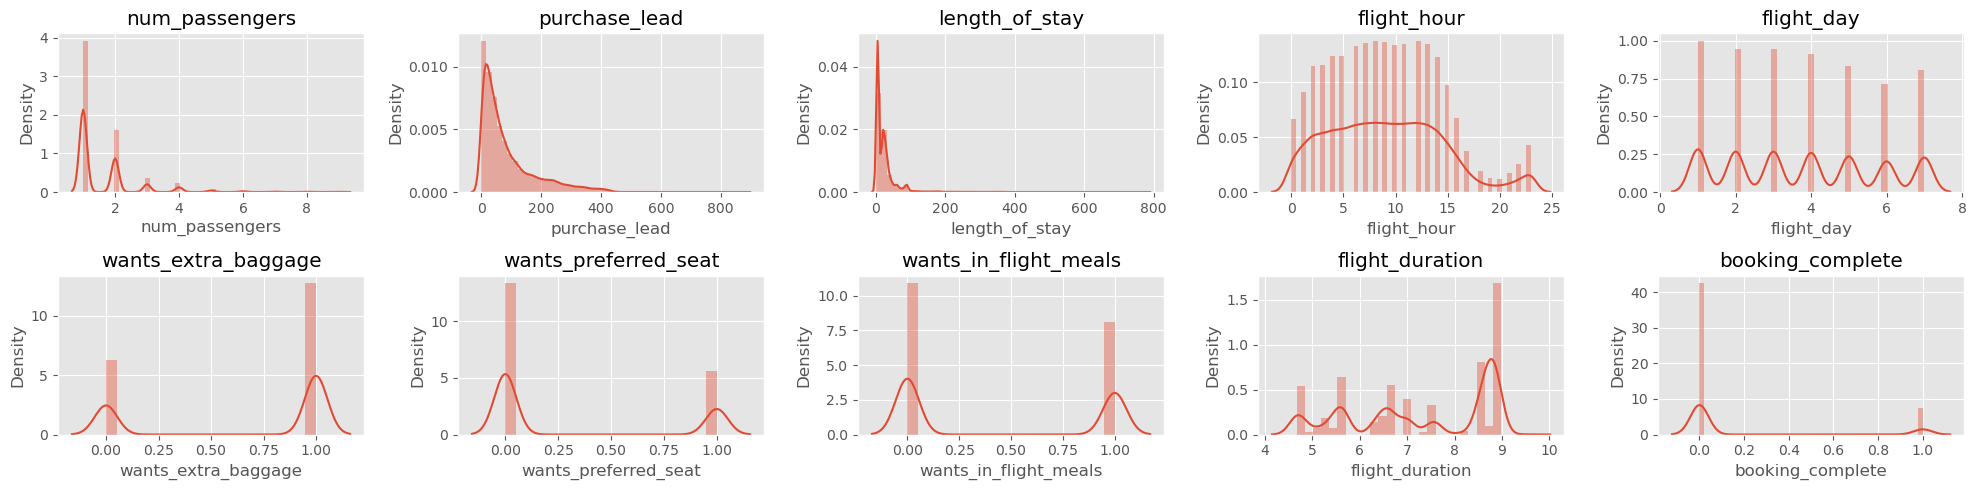

In [35]:
plt.figure(figsize=(20, 5))
for  index, col in enumerate(df_int.columns):
    plt.subplot(2,5,index+1)
    sns.distplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

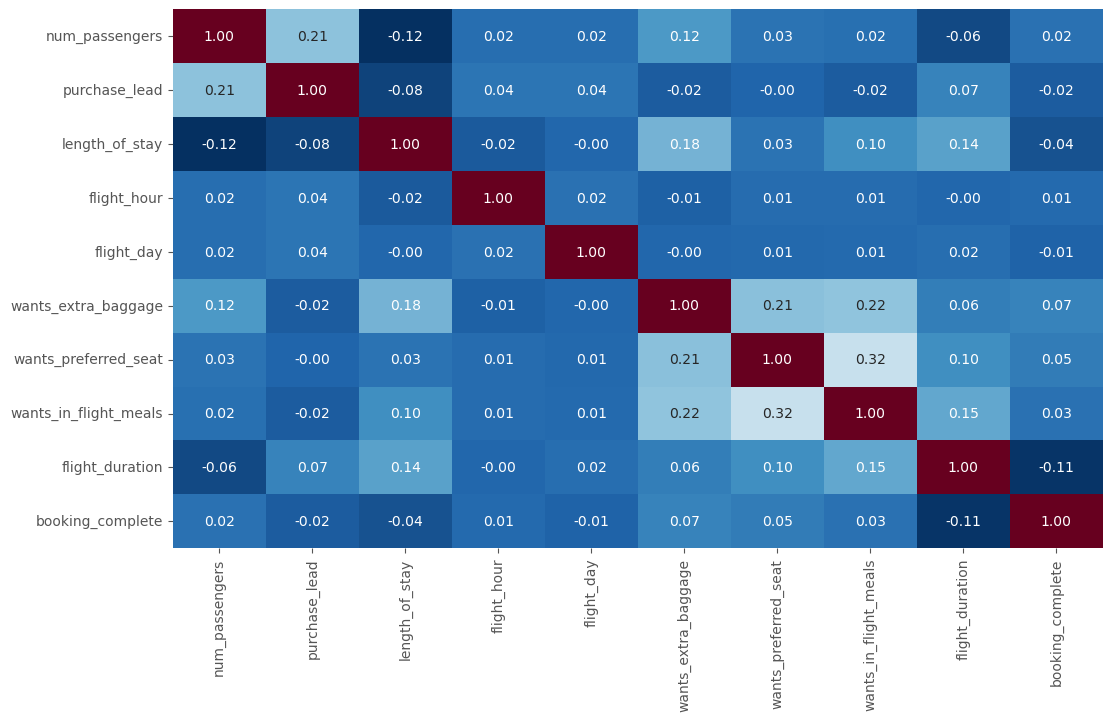

In [36]:
corr = df_int.corr()
plt.subplots(figsize=(12,7))
sns.heatmap(corr,annot=True,fmt='.2f',cmap='RdBu_r',cbar=False)  
plt.show()     

# **TASK 2: DATA ENGINEERING**

**split data into train and test set**

In [37]:
pred = df.drop('booking_complete',axis=1)
target = df['booking_complete']
X,X_test,y,y_test = train_test_split(pred,target,test_size=0.15,random_state=42,shuffle= True)

In [38]:
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.2,random_state=42,shuffle= True)

In [39]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape

((34000, 13), (34000,), (8500, 13), (8500,), (7500, 13), (7500,))

**create a dictionary for models**

In [40]:
models = {'Logistic Regression':LogisticRegression(random_state=42),
          'XGBClassifier':XGBClassifier(random_state=42),
          'RandomForestClassifier':RandomForestClassifier(random_state=42)}

**define transformers for feature engineering with scaling**


In [43]:
numeric_features = ['num_passengers','purchase_lead' ,'length_of_stay','flight_hour','flight_duration']
numeric_transformer =  MinMaxScaler()
categorical_transformer = OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, selector(dtype_include=object))],
    remainder= 'passthrough')

In [45]:
for model in models:
  pipeline = Pipeline(  
    steps=[
        ('transformer', preprocessor),
        ('model', models[model])])
  pipeline.fit(X_train,y_train)
  print(f'{model} Report On Scaled data')
  print(f'accuracy on training set {pipeline.score(X_train,y_train)}')
  val_pred = pipeline.predict(X_val)
  print(classification_report(y_val, val_pred))
  print(f'accuracy on validation set {accuracy_score(y_val, val_pred)}')
  print(f'balanced accuracy on validation set {balanced_accuracy_score(y_val, val_pred)}')
  print('''=====================================
         
         ''')

Logistic Regression Report On Scaled data
accuracy on training set 0.8499705882352941
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      7258
           1       0.45      0.07      0.11      1242

    accuracy                           0.85      8500
   macro avg       0.65      0.53      0.52      8500
weighted avg       0.80      0.85      0.80      8500

accuracy on validation set 0.8516470588235294
balanced accuracy on validation set 0.5257197455281728
         
         
XGBClassifier Report On Scaled data
accuracy on training set 0.8644411764705883
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      7258
           1       0.52      0.09      0.15      1242

    accuracy                           0.85      8500
   macro avg       0.69      0.54      0.53      8500
weighted avg       0.81      0.85      0.81      8500

accuracy on validation set 0.8547058823529412
balanced accu

**get the feature importance from the best base model with scaled data**

In [46]:
importance = pipeline.named_steps['model'].feature_importances_
feature = pipeline.named_steps['transformer'].get_feature_names_out()
feature_imp2 = list(zip(feature,importance))
feature_imp_df = pd.DataFrame(feature_imp2,columns=['feature','importance']).sort_values(by='importance',ascending=False)
feature_imp_df.head(10)

,feature,importance
1,numeric__purchase_lead,0.154193
3,numeric__flight_hour,0.124964
2,numeric__length_of_stay,0.113418
866,remainder__flight_day,0.088803
0,numeric__num_passengers,0.047042
4,numeric__flight_duration,0.035679
817,categorical__booking_origin_Malaysia,0.027081
777,categorical__booking_origin_Australia,0.022957
869,remainder__wants_in_flight_meals,0.021271
868,remainder__wants_preferred_seat,0.018888


**Training the best model with the full train dataset**

In [47]:
rf = RandomForestClassifier(random_state=42)
numeric_features = ['num_passengers','purchase_lead' ,'length_of_stay','flight_hour','flight_duration']
numeric_transformer =  MinMaxScaler()
categorical_transformer = OneHotEncoder(drop='first',handle_unknown='ignore',sparse=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, selector(dtype_include=object))],
    remainder= 'passthrough')

rf_model = Pipeline(  
steps=[
    ('transformer', preprocessor),
    ('model',rf)])

rf_model

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric', MinMaxScaler(),
                                                  ['num_passengers',
                                                   'purchase_lead',
                                                   'length_of_stay',
                                                   'flight_hour',
                                                   'flight_duration']),
                                                 ('categorical',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f7ca0141160>)])),
                ('model', RandomForestClassifier(random_state=42))])

In [48]:
rf_model.fit(X,y)
print('Random Forest Classifier Report')
print(f'accuracy on training set {rf_model.score(X,y)}')
rf_pred = rf_model.predict(X_test)
print(classification_report(y_test, rf_pred))
print(f'accuracy on test set {accuracy_score(y_test, rf_pred)}')
print(f'balanced accuracy on test set {balanced_accuracy_score(y_test, rf_pred)}')
print('''=====================================
        
        ''')

Random Forest Classifier Report
accuracy on training set 0.999835294117647
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      6380
           1       0.51      0.13      0.21      1120

    accuracy                           0.85      7500
   macro avg       0.69      0.56      0.56      7500
weighted avg       0.81      0.85      0.81      7500

accuracy on test set 0.8513333333333334
balanced accuracy on test set 0.5556006493506493
        
        


In [61]:
importance = rf_model.named_steps['model'].feature_importances_
feature = rf_model.named_steps['transformer'].get_feature_names_out()
feature_imp2 = list(zip(feature,importance))
feature_imp_df = pd.DataFrame(feature_imp2,columns=['feature','importance']).sort_values(by='importance',ascending=False)
feature_imp_df.head()

,feature,importance
1,numeric__purchase_lead,0.158022
3,numeric__flight_hour,0.127936
2,numeric__length_of_stay,0.115154
886,remainder__flight_day,0.090632
0,numeric__num_passengers,0.047083


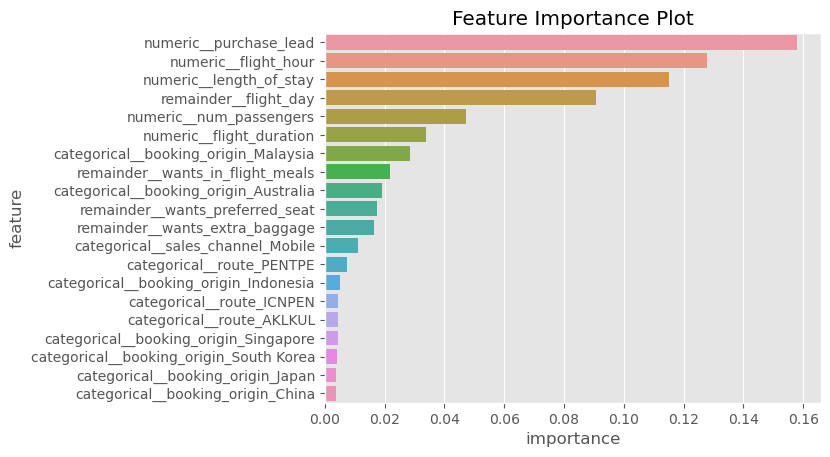

In [62]:
sns.barplot(data=feature_imp_df.head(20),x='importance',y='feature')
plt.title('Feature Importance Plot')
plt.show()

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.